# devlog 2023-08-17

_author: Tyler Coles_

Demonstrating the new initializer scheme.

## Initializer

An `Initializer` is a function that given the simulation context (and additional arbitrary parameters) returns the starting IPM compartments for each population in the geo model.

These used to be hard-coded into the IPM, but have now been extracted into standalone function implementations for greater flexibility. Now you are free to select an initializer from the library of built-in implementations (see `epymorph.initializer`), or even provide your own bespoke function. In either case, an auto-wiring procedure will attempt to fill in the initializer's data requirements (parameters) from the set of data available (mostly the geo model and simulation parameters).

We set up as usual by composing a Simulation from the three main modules.

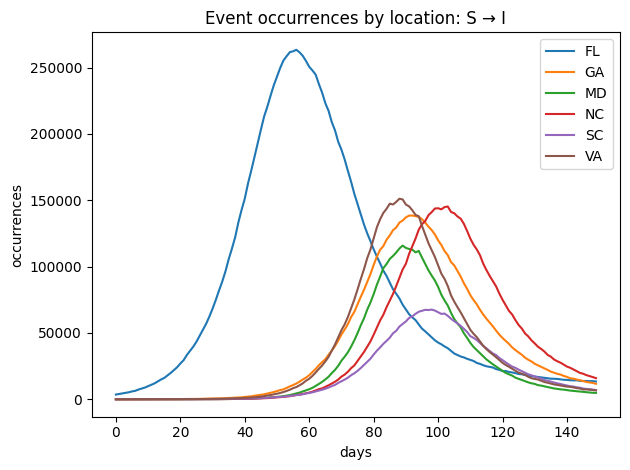

In [1]:
from datetime import date
from functools import partial

import numpy as np
from numpy.typing import NDArray

from epymorph.data import geo_library, ipm_library, mm_library
from epymorph.engine.standard_sim import StandardSimulation
from epymorph.initializer import single_location
from epymorph.plots import plot_event
from epymorph.simulation import SimDType, TimeFrame

# I'm going to be running all these sims with the same params and time frame,
# so we can create them here to avoid repeating ourselves.
params = {
    # ipm params
    'infection_duration': 4.0,
    'immunity_duration': 90.0,
    # movement params
    'theta': 0.1,
    'move_control': 0.9,
}

time_frame = TimeFrame(start_date=date(2015, 1, 1), duration_days=150)

# Recall that the pei IPM is an SIRS model and as such has three compartments.
# Each simulation run can have its own initializer.
sim = StandardSimulation(
    geo=geo_library['pei'](),
    ipm=ipm_library['pei'](),
    mm=mm_library['pei'](),
    params=params,
    time_frame=time_frame,
    # I'm using "partial function application" to set the parameters I care about.
    # epymorph will try to auto-wire any unset parameters from available data.
    initializer=partial(single_location, location=0, seed_size=10_000)
)

out = sim.run()

plot_event(out, 0)  # plot of daily new infections

## Running from the CLI with a TOML file

If you prefer to run epymorph from the command line, you can still select and configure initializers. To do this, you must supply an `[init]` section in the TOML. In this section you must include a key named `initializer` whose value is a string with the name of a built-in initializer function. The other keys in this section will be used as arguments to the initializer function.

_NOTE: At the moment there is no way to specify a bespoke initialization function when using the CLI._

The equivalent TOML file to the above simulation looks like this:

---
```toml
ipm = "pei"
mm = "pei"
geo = "pei"
start_date = 2015-01-01
duration_days = 150

[init]
initializer = "single_location"
location = 0
seed_size = 10_000

[params]
infection_duration = 4.0
immunity_duration = 90.0
theta = 0.1
move_control = 0.9
```
---

Note: any values that are lists in the TOML file are automatically converted to numpy arrays by epymorph.

## Other initializers

We can also initialize the compartments explicitly, but keep in mind this doesn't use the geo's population data, so it's on us to get the numbers right. (Or purposefully "wrong", I suppose!)

I've chosen these numbers to yield the same result as the previous example. (Of course due to RNG the plot will look slightly different.)

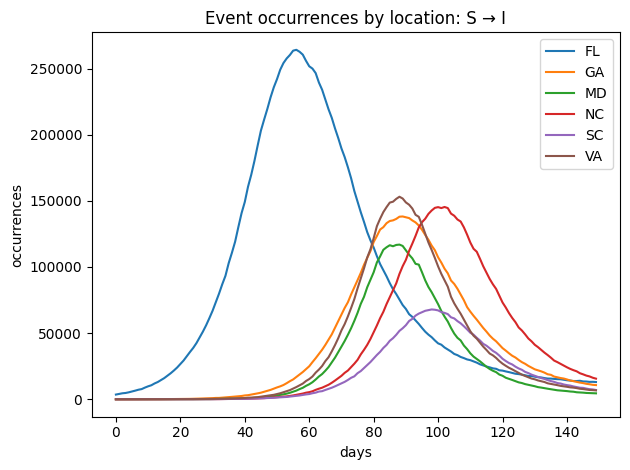

In [2]:
from epymorph.initializer import explicit

sim = StandardSimulation(
    geo=geo_library['pei'](),
    ipm=ipm_library['pei'](),
    mm=mm_library['pei'](),
    params=params,
    time_frame=time_frame,
    initializer=partial(explicit, initials=np.array([
        # S, I, R
        [18_801_310, 10_000, 0],  # FL
        [9_687_653, 0, 0],  # GA
        [5_773_552, 0, 0],  # MD
        [9_535_483, 0, 0],  # NC
        [4_625_364, 0, 0],  # SC
        [8_001_024, 0, 0],  # VA
    ]))
)

out = sim.run()

plot_event(out, 0)  # plot of daily new infections

Here's another built-in initializer -- `proportional` -- which will set each population's initial compartments according to the given ratios of their total population. Notice how each initializer takes a unique set of parameters that make sense for their implementation.

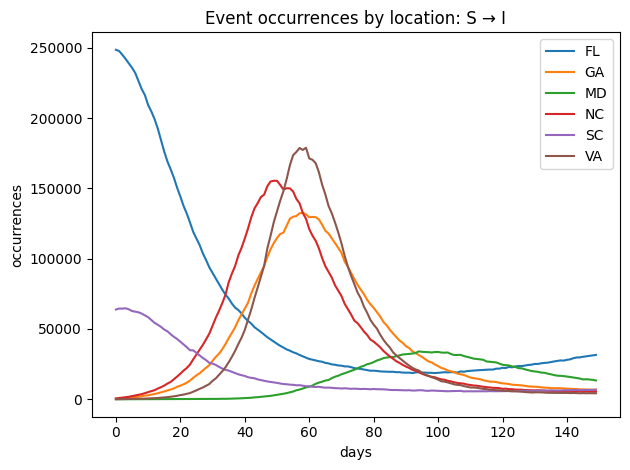

In [3]:
from epymorph.initializer import proportional

# These rows will be normalized, so are free to express the ratios however is convenient.
ratios = np.array([
    # S, I, R
    [75, 5, 20],  # FL
    [0.95, 0, 0.05],  # GA
    [1, 0, 1],  # MD
    [95, 0, 5],  # NC
    [75, 5, 20],  # SC
    [100, 0, 0],  # VA
])

sim = StandardSimulation(
    geo=geo_library['pei'](),
    ipm=ipm_library['pei'](),
    mm=mm_library['pei'](),
    params=params,
    time_frame=time_frame,
    initializer=partial(proportional, ratios=ratios)
)

out = sim.run()

plot_event(out, 0)  # plot of daily new infections

Now let's write a custom initializer.

Maybe I want my initialization logic to be influenced by the infection duration used by the IPM. No problem, we can write a function that does that!

By defining my function to take `population` and `infection_duration` parameters, I can expect that these values will be filled in from the available geo attributes and simulation parameters respectively. If auto-wiring fails to find a match, it will raise an `InitializationException`.

FL @ t=0, inf_dur=1: [18680920    65195    65195]
FL @ t=0, inf_dur=4: [18508554   151378   151378]
FL @ t=0, inf_dur=8: [18397983   206663   206663]


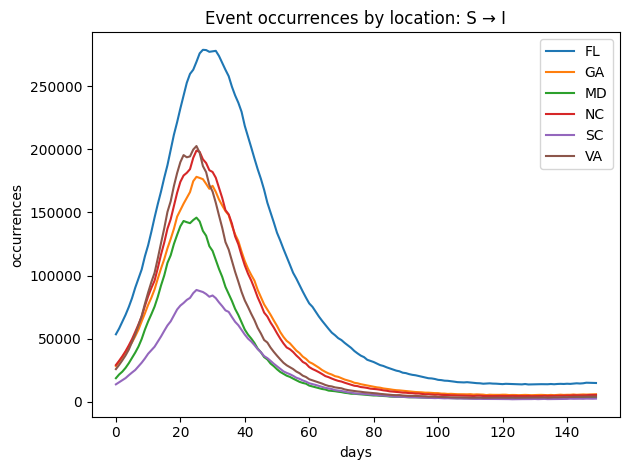

In [4]:
from math import log


def my_initializer(population: NDArray[np.integer], infection_duration: float) -> NDArray[SimDType]:
    # This calculation is arbitrary, just for demonstration.
    r = 0.005 * log(infection_duration + 1)
    ratios_sir = np.array([(1 - 2 * r), r, r])
    result = population[:, np.newaxis] * ratios_sir
    return result.round().astype(SimDType)


# Just as a quick check:
# see that higher infection_duration yields more individuals in the I and R compartments.
geo = geo_library['pei']()
pop = geo['population'].astype(np.int64)
print(f"FL @ t=0, inf_dur=1: {my_initializer(pop, 1.0)[0]}")
print(f"FL @ t=0, inf_dur=4: {my_initializer(pop, 4.0)[0]}")
print(f"FL @ t=0, inf_dur=8: {my_initializer(pop, 8.0)[0]}")


# And running the sim is straight-forward:
sim = StandardSimulation(
    geo=geo_library['pei'](),
    ipm=ipm_library['pei'](),
    mm=mm_library['pei'](),
    params=params,
    time_frame=time_frame,
    initializer=my_initializer
)

out = sim.run()

plot_event(out, 0)  # plot of daily new infections